# 

## Methods

In this project, we formulate two objectives:

**A**: Reproduce the Hi-C interaction maps and eigendecomposition from ([Wang et al. 2019](#ref-wang_reprogramming_2019)), with some modifications. We briefly use *HiCExplorer*, but change the analyses to use the *Open2C Ecosystem* ([Open Chromosome Collective 2024](#ref-open2c)) which have a Pyton API as well as command-line functions, which can be paired very well with Jupyter Notebooks. The majority of the data analysis was run with a *gwf* workflow, and the commands that were visually inspected were run in Jupyter Notebooks.

**B** Compare with regions of selection that are found in *papio anubis*, and maybe in *human* too. Investigate the biological meaning of the results.

All computations were performed on GenomeDK (GDK) \[ref\], an HPC cluster located on Aarhus Uninversity, and most of the processing of the data was nested into a *gwf* workflow \[ref\], a workflow manager developed at GDK. I would like to thank GDK and Aarhus University for providing computational resources and support that contributed to these research results.

The whole of this project is carried out with reproducibility in mind, so an effort (and quite a significant amount of time) has been put into documenting code and organizing the project for readbility and transparency through a Quarto project \[ref\]. Therefore, all code, virtual environments and text is made available as a Quarto book, rendered directly from the GitHub repository with GitHub Pages \[\]. To make this possible, the Quarto documentation has been extensively studied and discussed with *KMT* \[ref, aknowledge\].

### Downloading Data and Project Structure

To reproduce the results from ([Wang et al. 2019](#ref-wang_reprogramming_2019)), I chose to use their raw data directly from the SRA portal \[ref\]. I filtered the data to contain all their paired-end Hi-C reads, and included only macaque samples. The data set also contains RNAseq data, and the same tissues for both macaque and mouse. The meta data for the data set was extracted into a runtable `SRA-runtable.tsv`. To get an overview of the data accessions used in this analysis, we will first summarize the runtable that contains the accession numbers and some metadata for each sample (([**tbl-runtable-summary?**](#ref-tbl-runtable-summary))). It adds up to ~1Tb of compressed `fastq` files, holding ~9.5 billion reads, roughly evenly spread on the 5 tissue types.

``` python
display(df_grouped)
```

<style type="text/css">
</style>

      source_name              GB           Bases             Reads
  --- ------------------------ ------------ ----------------- ---------------
  0   fibroblast               211.403275   553,968,406,500   1,846,561,355
  1   pachytene spermatocyte   274.835160   715,656,614,700   2,385,522,049
  2   round spermatid          243.128044   655,938,457,200   2,186,461,524
  3   sperm                    164.131640   428,913,635,400   1,429,712,118
  4   spermatogonia            192.794420   518,665,980,300   1,728,886,601

### Handling coolers (Or: preparing coolers)

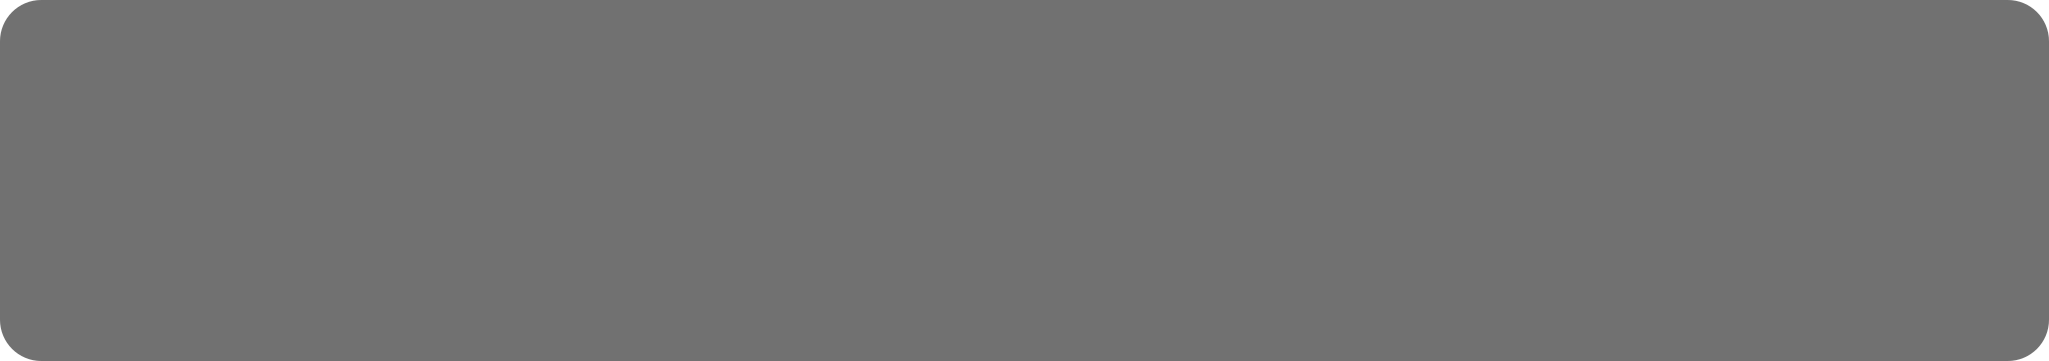{#fig-flowchart-handling-coolers width="90%"}

#### The *gwf* workflow targets

A *gwf* workflow was created to handle the first part of the data processing, and each accesion number (read pair, mate pair) from the Hi-C sequencing was processed in parallel, so their execution was independent from each other.

##### Downloading the reads

The reads were downloaded from NCBI SRA portal \[ref\] directly to GDK using `sra-downloader` \[ref\] through docker \[ref\] as `.fastq.gz` files.

##### Handling the reference

The latest reference genome for rhesus macaque (*macaca mulata*), *rheMac10* (or *Mmul_10*, UCSC or NCBI naming conventions, respectively) was downloaded to GDK from UCSC web servers with `wget` \[ref\]. To use `bwa` (Burrow Wheeler’s Aligner) \[ref\] for mapping, rheMac10 needs to be indexed with both `bwa index` with the `--bwtsw` option and `samtools faidx`, which results in six indexing files for `bwa mem` to use.

##### Mapping paired-end reads

##### Pair and sort the reads

##### Filter (deduplicate) pairs

##### Create interaction matrices (coolers)

#### Notebook edits

As `cooler` and `cooltools` have a Python API, the more experimental parts of the analysis were moved to Jupyter Notebooks (still running on GenomeDK)

##### Pooling samples (Merging coolers)

The samples are grouped into *replicates* with a unique **BioSample** ID, but we chose to pool all the interaction matrices for each cell type. We argue that when Wang et al. ([2019](#ref-wang_reprogramming_2019)) determine compartments to be highly reproducible between replicates, by merging the replicates we can get a more robust signal.

`cooler merge` was used to merge all samples in each sub-folder (cell type) to just one interaction matrix for each cell type. The function merges matrices of the same dimensions by simply adding the interaction frequencies of each genomic position together, resulting in less empty positions by chance.

##### Create multi-resolution coolers (zoomify)

A feature of working inside the ecosystem of *Open2C* \[ref\] is that it natively provides support for storing sparse interaction matrices in multiple resolutions in the same file by adding groups to the hdf5-file \[ref\]. We can then efficiently store resolutions (i.e., different bin sizes) that is multiples of the smallest bin size. We chose to use 10kb, 50kb, 100kb, and 500kb bins.

##### Matrix balancing (Iterative correction)

Finally, we balance the matrices using the cooler CLI. We use the `cooler balance` command with the default options using 32 cores, which iteratively balances the matrix (Iterative Corecction). It is first described as a method for bias correction of Hi-C matrices in ([Imakaev et al. 2012](#ref-imakaev_iterative_2012)), where it is paired with eigenvector decomposition (ICE). Here the eigenvector decomposition of the obtained maps is shown to provide insights into local chromatin states.

According to `cooler` documentation, we have to balance the matrices on each resolution, and thus it cannot be done prior to zoomifying. The argument is that the balancing weights are resolution-specific and will no longer retain its meaning when binned with other weights. Therefore, we use a nested for-loop that iterates through all the `.mcools` and all the resolutions in each `.mcool`. `cooler balance` will create a new column in the `bins` group of each cooler , `weight`, which can then be included or not in the downstream analysis. This means we will have access to both the balanced and the unbalanced matrix.

The default mode uses genome-wide data to calculate the weights for each bin. It would maybe be more suitable to calculate the weights for *cis* contacts only, and that is possible through the `--cis-only` flag, and that can be added to another column, so that we can compare the difference between the two methods easily. However, we will only use the default mode for now.

##### Eigendecomposition

Imakaev, Maxim, Geoffrey Fudenberg, Rachel Patton McCord, Natalia Naumova, Anton Goloborodko, Bryan R Lajoie, Job Dekker, and Leonid A Mirny. 2012. “Iterative Correction of Hi-C Data Reveals Hallmarks of Chromosome Organization.” *Nature Methods* 9 (10): 999–1003. <https://doi.org/10.1038/nmeth.2148>.

Open Chromosome Collective. 2024. “Open Chromosome Collective (Open2C).” Resource. *Open2C*. <https://open2c.github.io/>.

Wang, Yao, Hanben Wang, Yu Zhang, Zhenhai Du, Wei Si, Suixing Fan, Dongdong Qin, et al. 2019. “Reprogramming of Meiotic Chromatin Architecture During Spermatogenesis.” *Molecular Cell* 73 (3): 547–561.e6. <https://doi.org/10.1016/j.molcel.2018.11.019>.